# Lab 8 Report: 
## FINAL PROJECT STRATEGIC PLANNING

### Lab 8 Instruction: https://canvas.uw.edu/courses/1548925/files/92225287?wrap=1

### Team Members:

### Dataset for your project:

#### Feel free to delete or modify pre-written markdown cells below the line

---

## Understanding the Data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import math as math
from IPython.display import Image
import os
os.chdir('C:/Users/yuuki/jupyter-workspace/Lab_8_YuukiSawanoi/jets/jets')

## Understanding the Task

In [2]:
#size of image
x = 64
y = 64
#data type of numbers in image
data_type = np.float16

In [3]:
trs = 50000
tst = 1000
val = 1000

In [4]:
def center2(arr, c1x, c1y, c2x, c2y, c3x, c3y):
    c3x = np.sum(arr[:,1]*arr[:,3])
    c3y = np.sum(arr[:,2]*arr[:,3])
    return [c3x, c3y, c2x, c2y, c1x, c1y]

In [5]:
def image(arr, count, ix, iy, data_type):
    x = ix
    y = iy
    im = np.zeros((1,x,y))
    c = np.zeros(6)
    c = center2(arr, 0, 0, 0, 0, 0, 0)
    if c[2] != 0:
        adj = math.atan(c[3] / c[2])
        if c[2] < 0:
            adj += math.pi
    elif c[3] > 0:
        adj = math.pi / 2
    else:
        adj = - math.pi / 2
    
    theta = 0
    if c[0] != 0:
        theta = (math.atan(c[1] / c[0]))
        if c[0] < 0:
            theta += math.pi
    elif c[1] > 0:
        theta = math.pi / 2
    else:
        theta = - math.pi / 2
    flip = 1
    if math.sin(theta - adj) < 0:
        flip = -1
        
    new_x = (arr[:,1]*math.cos(-adj)-arr[:,2]*math.sin(-adj))
    new_y = ((arr[:,2]*math.cos(-adj)+arr[:,1]*math.sin(-adj))*flip)
    
    #arr[:,1] = new_x
    #arr[:,2] = flip*new_y

    length = len(new_x)
    new_x[0] = 0
    new_y[0] = 0
    j = np.zeros(length).astype(int)
    p = np.mod(new_x*x+x*7/16,x).astype(int)
    q = np.mod(new_y*y+y/2,y).astype(int)

    im[j,p,q] += np.maximum(np.log(arr[:,3])+13,j)
    return im.astype(data_type)

In [6]:
files = trs+tst+val
count = 0
dataset = np.zeros((0,x, y))
datas = []
target = np.zeros((files,))
plt.figure(figsize = (6, 120))
m = 0
s = 0

files = trs+tst+val
count = 0
dataset = np.zeros((files,x,y)).astype(data_type)
target = np.zeros((files,))
plt.figure(figsize = (6, 120))
m = 0
s = 0
for file in tqdm(os.listdir()):
    if files <= count:
        break
    with np.load(file) as data:
        t = data['y']
        #if (t[0] + t[1]) == 0:
        #    continue
        target[count] = (0 * t[0] + 0 * t[1] + 1 * t[2] + 1 * t[3] + 2 * t[4])
        a = image(data['x'], count, x, y, data_type)
        dataset[count] = a
        count += 1

  5%|███▉                                                                      | 52000/987683 [02:37<47:08, 330.79it/s]


<Figure size 432x8640 with 0 Axes>

<Figure size 432x8640 with 0 Axes>

100%|█████████████████████████████████████████████████████████████████████████| 52000/52000 [00:00<00:00, 84833.64it/s]


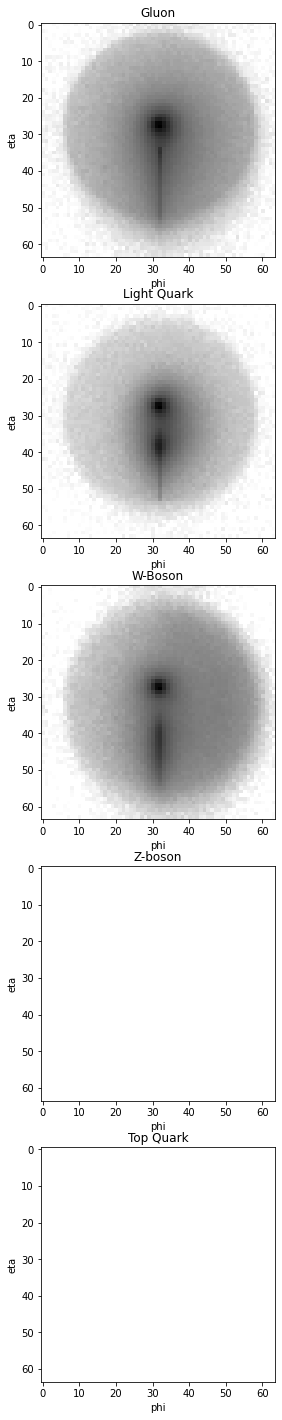

In [7]:
arr0 = np.zeros((5, len(dataset[0]), len(dataset[0][0])))
for i in tqdm(range(len(dataset))):
    arr0[round(target[i])] += dataset[i]
            
arr1 = np.zeros((5, len(dataset[0]), len(dataset[0][0])))
plt.figure(figsize = (5, 25))
arr2 = ["Gluon", "Light Quark", "W-Boson", "Z-boson", "Top Quark"]
for i in range(5):
    for p in range(len(dataset[i])):
        for q in range(len(dataset[i][p])):
            if(arr0[i][p][q] > 0):
                arr1[i][p][q] = max(math.log(arr0[i][p][q]) - 2, 0)
    plt.subplot(5, 1, i + 1)
    plt.imshow(arr1[i], cmap = 'Greys')
    plt.ylabel("eta")
    plt.xlabel("phi")
    plt.title(arr2[i])

In [8]:
from sklearn.preprocessing import StandardScaler

train_data = dataset[tst:].reshape((trs+val,1,  x, y))
test_data = dataset[:tst].reshape((tst,1,  x, y))
#train_data_flat = train_data.reshape((trs+val, 100 * 100))
#test_data_flat = test_data.reshape((tst, 100 * 100))
scaler = StandardScaler()
#train_data = scaler.fit_transform(train_data_flat).reshape((trs+val,1,  100, 100))
#test_data = scaler.fit_transform(test_data_flat).reshape((tst,1,  100, 100))
train_target = target[tst:]
test_target = target[:tst]


In [9]:
print(train_data.shape, test_data.shape, train_target.shape, test_target.shape)

(51000, 1, 64, 64) (1000, 1, 64, 64) (51000,) (1000,)


In [10]:
validation_data = train_data[:val]
validation_target = train_target[:val]

train_data = train_data[val:]
train_target = train_target[val:]

In [11]:
class CNNModel(torch.nn.Module):
    
    def __init__(self, x, y):
        
        super(CNNModel, self).__init__()
        
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                              kernel_size=3, stride=1, padding = 1)
    
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=3, stride=1, padding = 1)
        
        self.cnn3 = torch.nn.Conv2d(in_channels=32, out_channels=64, 
                              kernel_size=3, stride=1, padding = 1)
        
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = torch.nn.Linear((x//2//2//2)*(y//2//2//2)*64, 128)
        self.fc3 = torch.nn.Linear(128,3)
        
        self.dropout = torch.nn.Dropout(p = 0.5)
        
    def forward(self, x):
        
        out = torch.nn.functional.relu(self.cnn1(x)) 
        out = self.maxpool1(out)
        
       # out = self.dropout(out)
        out = torch.nn.functional.relu(self.cnn2(out))

        out = self.maxpool2(out)
        
        out = torch.nn.functional.relu(self.cnn3(out))
        out = self.maxpool3(out)
        
        #conv3_out = torch.nn.functional.relu(self.cnn3(pool2_out))    
        #pool3_out = self.maxpool3(conv3_out)
        
        fcn_input = out.view(out.size(0), -1)
        
        
        out = self.fc1((fcn_input))
        
        #out = self.fc2(out)
        
        out = self.fc3(out)
        
        return out

In [12]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel(x,y)

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.00005
epochs = 20
batchsize = 500

# Define loss function and optimizer

loss_func =torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.cuda()

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
train_loss_list = []
train_acc_list = []
validation_accuracy_list = np.zeros((epochs,))

In [14]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(train_data).float()
#train_batches_features = torch.split(torch.from_numpy(train_data), batchsize).float().cuda()

train_targets = torch.from_numpy(train_target).long().cuda()
#train_batches_targets = torch.split(torch.from_numpy(train_target).long(), batchsize).cuda()

validation_inputs = torch.from_numpy(validation_data).float().cuda()
validation_targets = torch.from_numpy(validation_target).long().cuda()

train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

batch_split_num = len(train_batches_features)

# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):

    for k in range(batch_split_num):
    
        optimizer.zero_grad()
    
        input_batch = train_batches_features[k].cuda()
        output_targets = train_batches_targets[k].cuda()
    
        train_batch_outputs = model(input_batch)

        loss = loss_func(train_batch_outputs, output_targets)

        correct = (torch.argmax(train_batch_outputs, dim=1) == 
                   output_targets).type(torch.FloatTensor)
        
        train_acc_list.append(correct.mean())
        
        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
        print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

        validation_accuracy_list[epoch] = correct.mean()


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 0 Validation Accuracy: 75.7%


  5%|████▏                                                                              | 1/20 [00:06<02:09,  6.82s/it]

Epoch: 1 Validation Accuracy: 76.6%


 10%|████████▎                                                                          | 2/20 [00:11<01:34,  5.27s/it]

Epoch: 2 Validation Accuracy: 78.0%


 15%|████████████▍                                                                      | 3/20 [00:15<01:21,  4.77s/it]

Epoch: 3 Validation Accuracy: 78.5%


 20%|████████████████▌                                                                  | 4/20 [00:19<01:12,  4.53s/it]

Epoch: 4 Validation Accuracy: 79.6%


 25%|████████████████████▊                                                              | 5/20 [00:23<01:05,  4.40s/it]

Epoch: 5 Validation Accuracy: 80.4%


 30%|████████████████████████▉                                                          | 6/20 [00:27<01:00,  4.32s/it]

Epoch: 6 Validation Accuracy: 80.4%


 35%|█████████████████████████████                                                      | 7/20 [00:31<00:55,  4.29s/it]

Epoch: 7 Validation Accuracy: 80.7%


 40%|█████████████████████████████████▏                                                 | 8/20 [00:36<00:51,  4.25s/it]

Epoch: 8 Validation Accuracy: 80.9%


 45%|█████████████████████████████████████▎                                             | 9/20 [00:40<00:46,  4.22s/it]

Epoch: 9 Validation Accuracy: 80.6%


 50%|█████████████████████████████████████████                                         | 10/20 [00:44<00:41,  4.20s/it]

Epoch: 10 Validation Accuracy: 80.9%


 55%|█████████████████████████████████████████████                                     | 11/20 [00:48<00:37,  4.21s/it]

Epoch: 11 Validation Accuracy: 80.8%


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:52<00:33,  4.21s/it]

Epoch: 12 Validation Accuracy: 80.5%


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:57<00:29,  4.21s/it]

Epoch: 13 Validation Accuracy: 80.4%


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [01:01<00:25,  4.21s/it]

Epoch: 14 Validation Accuracy: 80.4%


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [01:05<00:21,  4.20s/it]

Epoch: 15 Validation Accuracy: 80.6%


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [01:09<00:16,  4.18s/it]

Epoch: 16 Validation Accuracy: 80.7%


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [01:13<00:12,  4.16s/it]

Epoch: 17 Validation Accuracy: 80.8%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:17<00:08,  4.15s/it]

Epoch: 18 Validation Accuracy: 80.9%


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:21<00:04,  4.15s/it]

Epoch: 19 Validation Accuracy: 80.8%


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:26<00:00,  4.30s/it]


In [15]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

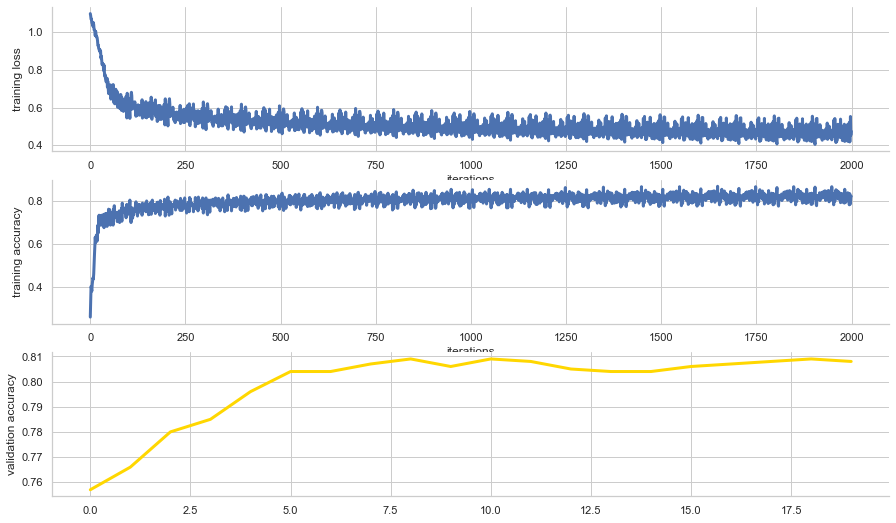

In [16]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(3, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(3, 1, 2)
plt.plot(train_acc_list, linewidth = 3)
plt.ylabel("training accuracy")
plt.xlabel("iterations")
sns.despine()

plt.subplot(3, 1, 3)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [18]:
# Compute the testing accuracy 
testing_inputs = torch.from_numpy(test_data).float().cuda()
testing_targets = torch.from_numpy(test_target).long().cuda()
with torch.no_grad():
    
    y_pred_test = model(testing_inputs)
    
    #correct = (torch.div(torch.argmax(y_pred_test, dim=1), 2, rounding_mode='floor') == (torch.div(testing_targets, 2, rounding_mode='floor'))).type(torch.FloatTensor)
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    wrong = np.zeros((5))
    total = np.zeros((5))
    for i in range(len(correct)):
        if(correct[i] == 0):
            #wrong[math.floor(test_target[i] / 2)] += 1
            wrong[int(test_target[i])] += 1
        #total[math.floor(test_target[i] / 2)] += 1
        total[int(test_target[i])] += 1

label = ["Gluon","Light Quark","W-Boson","Z-Boson","Top Quark"]

print(wrong)
print(total)

length = len(testing_targets)
arr = test_target == 0*np.ones(length)
for i in range(1,5):
    arr = np.concatenate([arr,test_target == i*np.ones(length)])
arr = arr.reshape(5,length)

for i in range(5):
    print("Accuracy of " + label[i] + ": " + str(float(np.sum(correct.numpy()*arr[i])/np.sum(arr[i])*100))+"%")
    
print("Overall Accuracy: " + str(float(correct.mean())*100) + "%")

[47. 65. 53.  0.  0.]
[382. 399. 219.   0.   0.]
Accuracy of Gluon: 87.69633507853402%
Accuracy of Light Quark: 83.70927318295739%
Accuracy of W-Boson: 75.79908675799086%
Accuracy of Z-Boson: nan%
Accuracy of Top Quark: nan%
Overall Accuracy: 83.49999785423279%


C:\Users\yuuki\AppData\Local\Temp\ipykernel_23528\3463718643.py:31: RuntimeWarning: invalid value encountered in true_divide
  print("Accuracy of " + label[i] + ": " + str(float(np.sum(correct.numpy()*arr[i])/np.sum(arr[i])*100))+"%")
